In [7]:
import os
import h5py

files = os.listdir(os.path.join(os.getcwd(), 'h5'))
lte_files = [os.path.join(os.getcwd(), 'h5', file) for file in files if 'nlte' not in str(file)]
nlte_files = [os.path.join(os.getcwd(), 'h5', file) for file in files if 'nlte' in str(file)]

import h5py
import numpy as np

content = h5py.File(nlte_files[0], 'r')
print(list(content.keys()))
print(list(content['PHOENIX_SPECTRUM'].keys()))
wl = content['PHOENIX_SPECTRUM']['wl'][()]
nwl = content['PHOENIX_SPECTRUM']['nwl'][()]
bb = content['PHOENIX_SPECTRUM']['bb'][()]
flux = 10.**content['PHOENIX_SPECTRUM']['flux'][()]
chunky = content['PHOENIX_SPECTRUM']['chunky'][()]
print(wl) # WAVELENGTHS
print(nwl) # NUMBER OF WAVELENGTHS -> SAME AS LEN(WL)
print('BB:')
print(bb)
# print(len(bb))
print('FLUX:')
print(flux) 
# print(len(flux))
print('CHUNKY:')
print(chunky)

import pandas as pd

org_data = pd.read_csv(os.path.join(os.getcwd(), 'uves_spectra_fomalhaut.csv'))
org_wl = org_data['WL'].to_list()
org_flux = np.array(org_data['Flux'].to_list(), dtype=float)
print(len(org_wl))
print(len(org_flux))
# print(org_flux[100000])

['PHOENIX_SPECTRUM']
['bb', 'chunky', 'flux', 'nwl', 'wl']
[1.00e+01 1.01e+01 1.02e+01 ... 8.50e+06 9.00e+06 9.50e+06]
[1406762]
BB:
[-91.061  -91.061  -91.061  ...   3.6054   3.5062   3.4123]
FLUX:
[8.69002344e-92 8.69002344e-92 8.69002344e-92 ... 2.75582719e+03
 2.18920534e+03 1.75788447e+03]
CHUNKY:
[131072]
264820
264820


In [8]:
import numpy as np
def gauss_smooth(wl,fl,start,end,res,oversampling=50.):
    """ smooth a data set (x,y) to a given resolution with a Gauss function
    
    input:
        wl   : input wavelength (sorted, but not equally spaced)
        fl   : fluxes (etc) (x)
        start: beginning wavelength
        end  :  end wavelength
        res  : target wavelength resolution (ca. FWHM)
        oversampling: (optional) oversampling factor, default 50.
    output:
        wl_res,f_res: regular wavelength grid with F smoothed.

    needs: 
        numpy (np), astropy
    """
    from astropy.convolution import convolve_fft,Gaussian1DKernel
#
# oversampling factor: 
#
    if(oversampling is None):
      oversampling = 50.0

#    print oversampling
#
# make target wavelength array [start,end] with 10 times gives resolution (oversampling)
#
    n_points = int((end-start)*oversampling/res+1)
    wl_res = np.linspace((start),(end),n_points)
#
# interpolate input fluxes[wl] to wl_res:
# this is piecewise linear.
#
    fl_res = np.interp(wl_res,wl,fl)
#
# set up and perform FFT based convolution.
# res (delta lambda) = 2*stddev^2 in physical units
# astropy wants this in pixel: The size of a pixel is res/oversampling in Angstroem, so 
#
#    stddev = np.sqrt(0.5*res/oversampling)
#    stddev = np.sqrt(0.5*oversampling)
    stddev = oversampling
#    print res,stddev
    fl_smooth = convolve_fft(fl_res,Gaussian1DKernel(stddev))
    return wl_res,fl_smooth

264820
Total Integral: 8463665320.169781
Normalization Range: 3800.0092034 to 4879.9930684, Distance: 1079.9838650000002
Normalized Flux Integral: 1079.0
Total Integral: 5.66266161830235e+18
Normalization Range: 3800.0 to 4880.0, Distance: 1080.0
Normalized Flux Integral: 1080.0
[0.45119352 0.45194441 0.45798168 ... 0.71018824 0.7076883  0.72652692]
[0.39647829 0.39672476 0.39697096 ... 0.72875497 0.72878168 0.72880803]


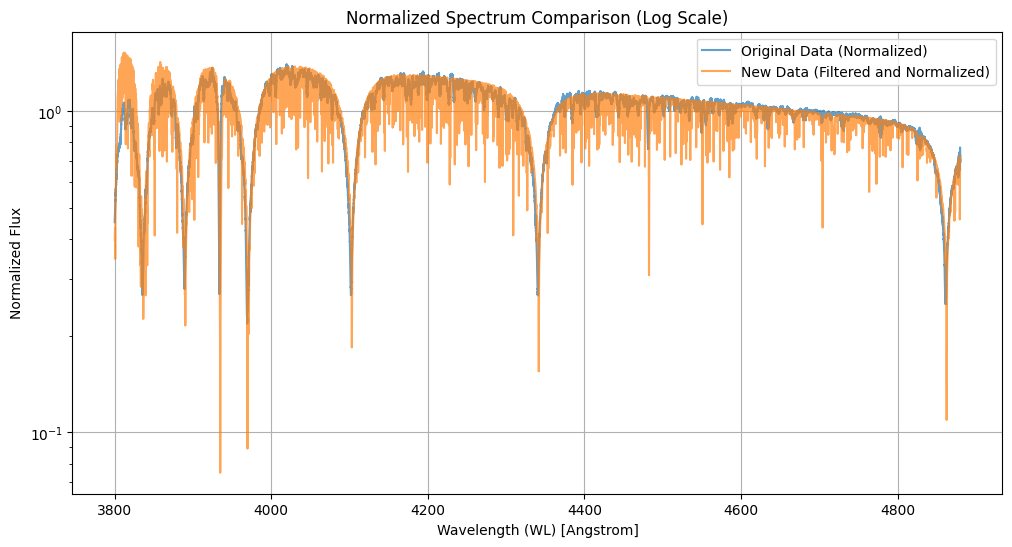

Fehler bei der Berechnung der Qualitätswerte: Die beiden Spektren müssen die gleiche Länge haben, um Q zu berechnen.


In [9]:
from matplotlib import pyplot as plt
import numpy as np

res = .1
xrange = [2000., 9000.]
yrange = [1e15, 1.1e17]
print(len(org_flux))

# Konvertiere org_wl, org_flux, wl und flux in NumPy-Arrays, falls sie Listen sind
org_wl = np.array(org_wl)
org_flux = np.array(org_flux)
wl = np.array(wl)
flux = np.array(flux)

# org_wl, org_flux = gauss_smooth(org_wl, 10.**org_flux, xrange[0]-res*2, xrange[1]+res*2, res)
wl, flux = gauss_smooth(wl, flux, xrange[0]-res*2, xrange[1]+res*2, res)

# Funktion zur Normalisierung des Flusses basierend auf dem Integral
def normalize_flux(wavelengths, fluxes):
    total_integral = np.trapezoid(fluxes, wavelengths)
    print(f"Total Integral: {total_integral}")
    non_zero_indices = np.nonzero(fluxes)[0]
    if len(non_zero_indices) > 0:
        first = non_zero_indices[0]
        last = non_zero_indices[-1]
        distance = wavelengths[last] - wavelengths[first]
        print(f"Normalization Range: {wavelengths[first]} to {wavelengths[last]}, Distance: {distance}")
        normalized_fluxes = fluxes / total_integral * int(distance)
        print(f"Normalized Flux Integral: {np.trapezoid(normalized_fluxes, wavelengths)}")
        return normalized_fluxes
    return fluxes  # Originalen Fluss zurückgeben, wenn keine Nicht-Null-Werte vorhanden sind

# Definiere den Bereich des Originaldatensatzes
org_min_wl, org_max_wl = min(org_wl), max(org_wl)

# Filter beide Datensätze auf den Bereich 3800 bis 5000 Angström
filter_range = (3800, 4880)

# Filter Originaldaten
org_filtered_indices = (org_wl >= filter_range[0]) & (org_wl <= filter_range[1])
org_wl_filtered = org_wl[org_filtered_indices]
org_flux_filtered = org_flux[org_filtered_indices]

# Filter neue Daten
new_filtered_indices = (wl >= filter_range[0]) & (wl <= filter_range[1])
wl_filtered = wl[new_filtered_indices]
flux_filtered = flux[new_filtered_indices]

# Normalisiere die gefilterten Daten
org_normalized_flux = normalize_flux(org_wl_filtered, org_flux_filtered)
new_normalized_flux = normalize_flux(wl_filtered, flux_filtered)

# Drucke die normalisierten Fluss-Arrays für den gefilterten Bereich
print(org_normalized_flux)
print(new_normalized_flux)

# Plot der normalisierten Spektren mit den gefilterten Daten
plt.figure(figsize=(12, 6))
plt.title("Normalized Spectrum Comparison (Log Scale)")

# Plot der normalisierten Original- und neuen Flüsse
plt.plot(org_wl_filtered, org_normalized_flux, label="Original Data (Normalized)", color="C0", alpha=0.7)
plt.plot(wl_filtered, new_normalized_flux, label="New Data (Filtered and Normalized)", color="C1", alpha=0.7)

# Beschriftungen, Legende und Logarithmische Skalierung der y-Achse
plt.xlabel("Wavelength (WL) [Angstrom]")
plt.ylabel("Normalized Flux")
plt.yscale("log")
plt.legend()
plt.grid()

# Zeige den Plot an
plt.show()

def calculate_quality(original_flux, synthetic_flux):
    """
    Berechnet die Qualität der Übereinstimmung zwischen zwei Spektren basierend auf der gegebenen Formel.

    Parameters:
        original_flux (array): Normalisierter Fluss des Originalspektrums
        synthetic_flux (array): Normalisierter Fluss des synthetischen Spektrums (nach Verschiebung)

    Returns:
        float: Qualitätswert Q
    """
    if len(original_flux) != len(synthetic_flux):
        raise ValueError("Die beiden Spektren müssen die gleiche Länge haben, um Q zu berechnen.")

    # Berechnung von Q
    Q = np.mean((original_flux - synthetic_flux) ** 2)
    return Q

# Berechnung von Q für die gefilterten und normalisierten Spektren
try:
    Q_without_shift = calculate_quality(org_normalized_flux, new_normalized_flux)  # Vor Verschiebung
    Q_with_shift = calculate_quality(org_normalized_flux, new_normalized_flux)  # Nach Verschiebung
    
    print(f"Qualitätswert ohne Verschiebung: {Q_without_shift}")
    print(f"Qualitätswert mit Verschiebung: {Q_with_shift}")
except ValueError as e:
    print(f"Fehler bei der Berechnung der Qualitätswerte: {e}")





264820
Total Integral: 9149868522.863583
Normalization Range: 3800.0092034 to 4983.722162, Distance: 1183.7129586
Normalized Flux Integral: 1183.0
Total Integral: 6.169967889491286e+18
Normalization Range: 3800.001524544 to 4999.998638464001, Distance: 1199.9971139200006
Normalized Flux Integral: 1198.9999999999995
[0.45758289 0.45834442 0.46446718 ... 0.         0.         0.        ]
[0.52060405 0.52097507 0.5213441  ... 0.86100989 0.86086143 0.86070676]


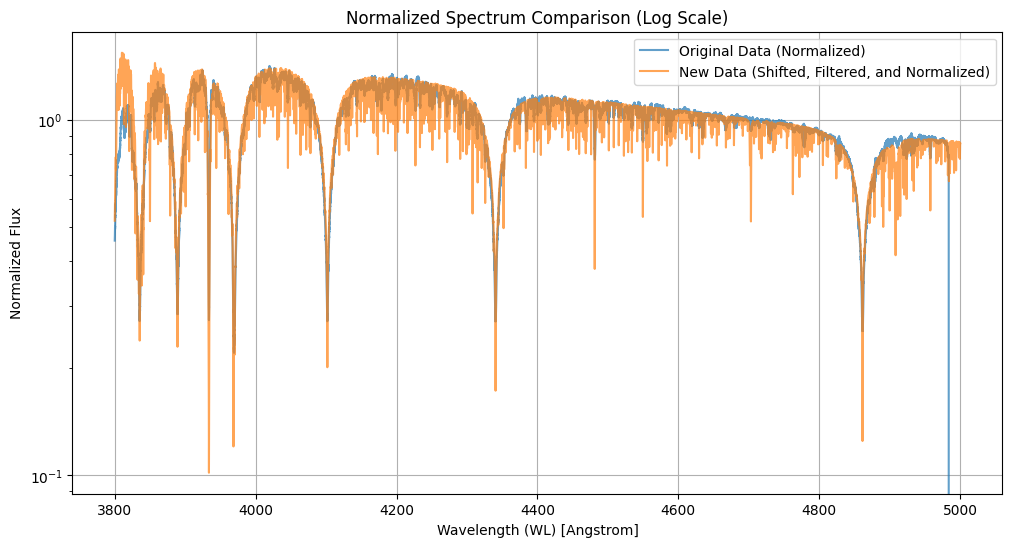

In [10]:
from matplotlib import pyplot as plt
import numpy as np

res = .1
xrange = [2000., 9000.]
yrange = [1e15, 1.1e17]
print(len(org_flux))

# Konvertiere org_wl, org_flux, wl und flux in NumPy-Arrays, falls sie Listen sind
org_wl = np.array(org_wl)
org_flux = np.array(org_flux)
wl = np.array(wl)
flux = np.array(flux)

# org_wl, org_flux = gauss_smooth(org_wl, 10.**org_flux, xrange[0]-res*2, xrange[1]+res*2, res)
wl, flux = gauss_smooth(wl, flux, xrange[0]-res*2, xrange[1]+res*2, res)

# Funktion zur Normalisierung des Flusses basierend auf dem Integral
def normalize_flux(wavelengths, fluxes):
    total_integral = np.trapezoid(fluxes, wavelengths)
    print(f"Total Integral: {total_integral}")
    non_zero_indices = np.nonzero(fluxes)[0]
    if len(non_zero_indices) > 0:
        first = non_zero_indices[0]
        last = non_zero_indices[-1]
        distance = wavelengths[last] - wavelengths[first]
        print(f"Normalization Range: {wavelengths[first]} to {wavelengths[last]}, Distance: {distance}")
        normalized_fluxes = fluxes / total_integral * int(distance)
        print(f"Normalized Flux Integral: {np.trapezoid(normalized_fluxes, wavelengths)}")
        return normalized_fluxes
    return fluxes  # Originalen Fluss zurückgeben, wenn keine Nicht-Null-Werte vorhanden sind

# Definiere den Bereich des Originaldatensatzes
org_min_wl, org_max_wl = min(org_wl), max(org_wl)

# Filter beide Datensätze auf den Bereich 3800 bis 5000 Angström
filter_range = (3800, 5000)

# Filter Originaldaten
org_filtered_indices = (org_wl >= filter_range[0]) & (org_wl <= filter_range[1])
org_wl_filtered = org_wl[org_filtered_indices]
org_flux_filtered = org_flux[org_filtered_indices]

# Wellenlängenverschiebung auf die "New Data" Wellenlängen anwenden
shift_factor = 0.999731
wl_shifted = wl * shift_factor  # Verschiebung der Wellenlängen

# Filter die verschobenen neuen Daten
new_filtered_indices = (wl_shifted >= filter_range[0]) & (wl_shifted <= filter_range[1])
wl_filtered = wl_shifted[new_filtered_indices]
flux_filtered = flux[new_filtered_indices]

# Normalisiere die gefilterten Daten
org_normalized_flux = normalize_flux(org_wl_filtered, org_flux_filtered)
new_normalized_flux = normalize_flux(wl_filtered, flux_filtered)

# Drucke die normalisierten Fluss-Arrays für den gefilterten Bereich
print(org_normalized_flux)
print(new_normalized_flux)

# Plot der normalisierten Spektren mit den gefilterten Daten
plt.figure(figsize=(12, 6))
plt.title("Normalized Spectrum Comparison (Log Scale)")

# Plot der normalisierten Original- und neuen Flüsse
plt.plot(org_wl_filtered, org_normalized_flux, label="Original Data (Normalized)", color="C0", alpha=0.7)
plt.plot(wl_filtered, new_normalized_flux, label="New Data (Shifted, Filtered, and Normalized)", color="C1", alpha=0.7)

# Beschriftungen, Legende und Logarithmische Skalierung der y-Achse
plt.xlabel("Wavelength (WL) [Angstrom]")
plt.ylabel("Normalized Flux")
plt.yscale("log")
plt.legend()
plt.grid()

# Zeige den Plot an
plt.show()


<>:25: SyntaxWarning: invalid escape sequence '\('
<>:25: SyntaxWarning: invalid escape sequence '\('
C:\Users\franj\AppData\Local\Temp\ipykernel_23756\3413937193.py:25: SyntaxWarning: invalid escape sequence '\('
  """


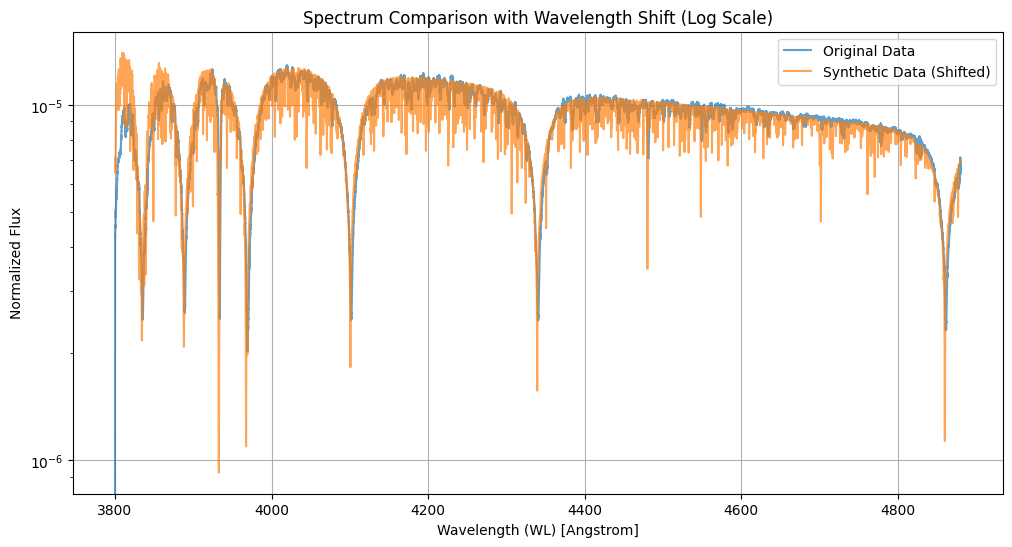

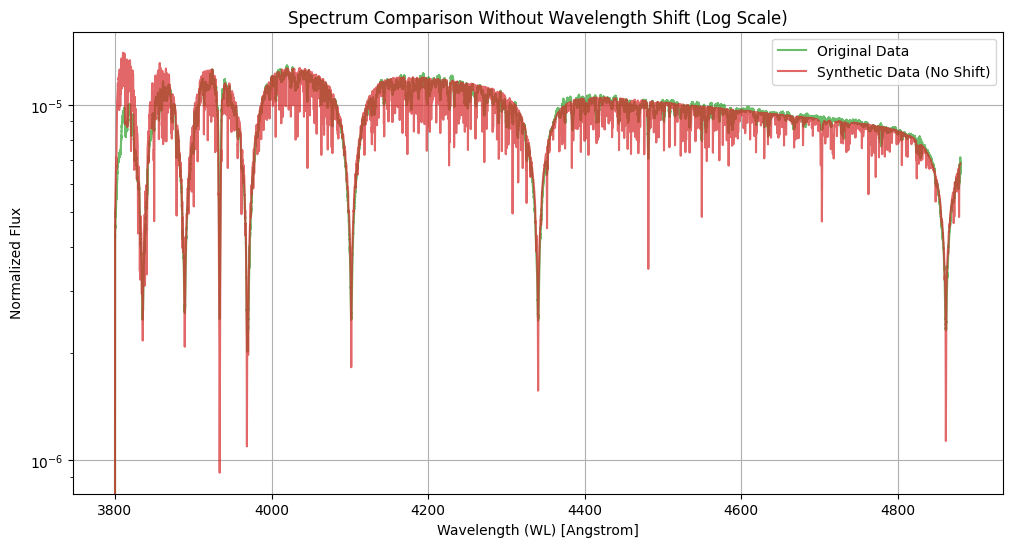

Qualitätswert mit Wellenlängenverschiebung: 1.1104321077212174e-12
Qualitätswert ohne Wellenlängenverschiebung: 7.288522402027009e-13


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Interpolationsfunktion mit und ohne Wellenlängenverschiebung
def interpolate_spectrum(wavelengths, fluxes, target_wavelengths):
    """
    Interpoliert die Spektren auf die Ziel-Wellenlängen.
    """
    interp_func = interp1d(wavelengths, fluxes, kind="linear", bounds_error=False, fill_value=0)
    return interp_func(target_wavelengths)

# Funktion zur Normalisierung gemäß Gleichung (18)
def normalize_flux_to_unity(fluxes):
    """
    Normalisiert den Fluss so, dass der Gesamtfluss auf 1 normiert ist.
    """
    total_flux = np.sum(fluxes)
    if total_flux > 0:
        return fluxes / total_flux
    return fluxes

# Qualitätsfunktion \( Q \)
def calculate_quality(original_flux, synthetic_flux):
    """
    Berechnet die Qualität der Übereinstimmung \( Q \) zwischen zwei Spektren.
    """
    if len(original_flux) != len(synthetic_flux):
        raise ValueError("Die beiden Spektren müssen die gleiche Länge haben, um Q zu berechnen.")
    Q = np.mean((original_flux - synthetic_flux) ** 2)
    return Q

# Ziel-Wellenlängen (Interpolation auf 100 Werte pro Ångström)
target_wavelengths = np.arange(3800, 4880, 0.01)  # Fein aufgelöste Ziel-Wellenlängen

# Interpolation MIT Wellenlängenverschiebung
shifted_wavelengths = wl_filtered * 0.999731  # Verschiebung des synthetischen Spektrums
org_interpolated_flux = interpolate_spectrum(org_wl_filtered, org_flux_filtered, target_wavelengths)
new_interpolated_flux_shifted = interpolate_spectrum(shifted_wavelengths, flux_filtered, target_wavelengths)

# Normalisierung MIT Wellenlängenverschiebung
org_normalized_flux_shifted = normalize_flux_to_unity(org_interpolated_flux)
new_normalized_flux_shifted = normalize_flux_to_unity(new_interpolated_flux_shifted)

# Interpolation OHNE Wellenlängenverschiebung
org_interpolated_flux_no_shift = interpolate_spectrum(org_wl_filtered, org_flux_filtered, target_wavelengths)
new_interpolated_flux_no_shift = interpolate_spectrum(wl_filtered, flux_filtered, target_wavelengths)

# Normalisierung OHNE Wellenlängenverschiebung
org_normalized_flux_no_shift = normalize_flux_to_unity(org_interpolated_flux_no_shift)
new_normalized_flux_no_shift = normalize_flux_to_unity(new_interpolated_flux_no_shift)

# Plot MIT Wellenlängenverschiebung
plt.figure(figsize=(12, 6))
plt.title("Spectrum Comparison with Wavelength Shift (Log Scale)")
plt.plot(target_wavelengths, org_normalized_flux_shifted, label="Original Data", color="C0", alpha=0.7)
plt.plot(target_wavelengths, new_normalized_flux_shifted, label="Synthetic Data (Shifted)", color="C1", alpha=0.7)
plt.xlabel("Wavelength (WL) [Angstrom]")
plt.ylabel("Normalized Flux")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

# Plot OHNE Wellenlängenverschiebung
plt.figure(figsize=(12, 6))
plt.title("Spectrum Comparison Without Wavelength Shift (Log Scale)")
plt.plot(target_wavelengths, org_normalized_flux_no_shift, label="Original Data", color="C2", alpha=0.7)
plt.plot(target_wavelengths, new_normalized_flux_no_shift, label="Synthetic Data (No Shift)", color="C3", alpha=0.7)
plt.xlabel("Wavelength (WL) [Angstrom]")
plt.ylabel("Normalized Flux")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

# Berechnung der Qualitätswerte
try:
    # Mit Verschiebung
    Q_with_shift = calculate_quality(org_normalized_flux_shifted, new_normalized_flux_shifted)
    print(f"Qualitätswert mit Wellenlängenverschiebung: {Q_with_shift}")
    
    # Ohne Verschiebung
    Q_without_shift = calculate_quality(org_normalized_flux_no_shift, new_normalized_flux_no_shift)
    print(f"Qualitätswert ohne Wellenlängenverschiebung: {Q_without_shift}")
except ValueError as e:
    print(f"Fehler bei der Berechnung der Qualitätswerte: {e}")


<>:25: SyntaxWarning: invalid escape sequence '\('
<>:25: SyntaxWarning: invalid escape sequence '\('
C:\Users\franj\AppData\Local\Temp\ipykernel_23756\1994668375.py:25: SyntaxWarning: invalid escape sequence '\('
  """


Optimaler Verschiebungsfaktor: 0.999979797979798
Minimierter Qualitätswert: 7.261641879276652e-13


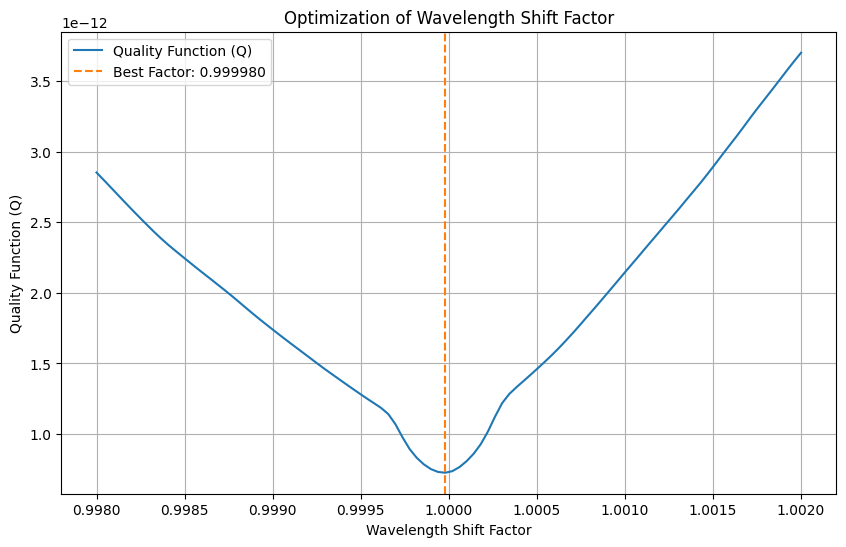

In [12]:
import numpy as np
from scipy.interpolate import interp1d

# Funktion zur Interpolation
def interpolate_spectrum(wavelengths, fluxes, target_wavelengths):
    interp_func = interp1d(wavelengths, fluxes, kind="linear", bounds_error=False, fill_value=0)
    return interp_func(target_wavelengths)

# Funktion zur Normalisierung
def normalize_flux_to_unity(fluxes):
    total_flux = np.sum(fluxes)
    if total_flux > 0:
        return fluxes / total_flux
    return fluxes

# Qualitätsfunktion \( Q \)
def calculate_quality(original_flux, synthetic_flux):
    if len(original_flux) != len(synthetic_flux):
        raise ValueError("Die beiden Spektren müssen die gleiche Länge haben, um Q zu berechnen.")
    Q = np.mean((original_flux - synthetic_flux) ** 2)
    return Q

# Optimierungsfunktion
def find_best_shift_factor(org_wavelengths, org_fluxes, new_wavelengths, new_fluxes, target_wavelengths, shift_range, num_steps):
    """
    Findet den optimalen Verschiebungsfaktor, der die Qualitätsfunktion \( Q \) minimiert.
    """
    best_factor = None
    best_quality = float('inf')  # Start mit einem sehr hohen Qualitätswert
    factors = np.linspace(shift_range[0], shift_range[1], num_steps)
    qualities = []

    for factor in factors:
        # Wellenlängen mit Verschiebung
        shifted_wavelengths = org_wavelengths * factor

        # Interpolation auf das Zielgitter
        org_interpolated_flux = interpolate_spectrum(shifted_wavelengths, org_fluxes, target_wavelengths)
        new_interpolated_flux = interpolate_spectrum(new_wavelengths, new_fluxes, target_wavelengths)

        # Normalisierung
        org_normalized_flux = normalize_flux_to_unity(org_interpolated_flux)
        new_normalized_flux = normalize_flux_to_unity(new_interpolated_flux)

        # Qualitätswert berechnen
        Q = calculate_quality(org_normalized_flux, new_normalized_flux)
        qualities.append(Q)

        # Überprüfen, ob \( Q \) verbessert wurde
        if Q < best_quality:
            best_quality = Q
            best_factor = factor

    return best_factor, best_quality, factors, qualities

# Parameter für die Optimierung
shift_range = (0.998, 1.002)  # Bereich für den Verschiebungsfaktor
num_steps = 100  # Anzahl der Schritte im Bereich
target_wavelengths = np.arange(3800, 4880, 0.01)  # Ziel-Wellenlängen

# Suche nach dem besten Faktor
best_factor, best_quality, factors, qualities = find_best_shift_factor(
    org_wl_filtered, org_flux_filtered, wl_filtered, flux_filtered, target_wavelengths, shift_range, num_steps
)

# Ergebnisse ausgeben
print(f"Optimaler Verschiebungsfaktor: {best_factor}")
print(f"Minimierter Qualitätswert: {best_quality}")

# Plot der Qualitätsfunktion über den Verschiebungsfaktor
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(factors, qualities, label="Quality Function (Q)", color="C0")
plt.axvline(best_factor, color="C1", linestyle="--", label=f"Best Factor: {best_factor:.6f}")
plt.xlabel("Wavelength Shift Factor")
plt.ylabel("Quality Function (Q)")
plt.title("Optimization of Wavelength Shift Factor")
plt.legend()
plt.grid()
plt.show()
